# TD 4 - Topological Persistence


*by Joseph DE ROFFIGNAC and Ten NGUYEN HANAOKA* 

The purpose of this notebook is to address all the exercises from Lab Session 4 (INF556 – TD4), which focuses on implementing an algorithm to compute persistent homology with coefficients in the field ℤ/2ℤ (also denoted ℤ₂), and on testing it across various filtrations.

### Let's start with some imports !

In [1]:
%pip install tqdm
%pip install plotly

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import read_filtration, plot_barcodes

Matplotlib is building the font cache; this may take a moment.


We are provided with a Simplex class (see simplex.py for more details) that contains three attributes:
* val (float): the time of appearance in the filtration,
* dim (int): the dimension,
* vert (list[int]): the list of vertex IDs (integers).

In addition, a read_filtration function in utils.py is available, which takes a filename (str) as input and returns a filtration represented as a list of simplices.

An example of how to use read_filtration is given just below :

In [3]:
filtration = read_filtration("filtrations/filtration_test.txt")
for simplex in filtration:
    print(simplex)
type(filtration[0])

{'time': 1.0, 'dim': 0, 'vert': {2}}
{'time': 1.0, 'dim': 0, 'vert': {4}}
{'time': 1.0, 'dim': 0, 'vert': {1}}
{'time': 2.0, 'dim': 1, 'vert': {2, 4}}
{'time': 2.0, 'dim': 1, 'vert': {1, 2}}
{'time': 3.0, 'dim': 0, 'vert': {7}}
{'time': 4.0, 'dim': 1, 'vert': {4, 7}}
{'time': 4.0, 'dim': 1, 'vert': {1, 7}}
{'time': 5.0, 'dim': 1, 'vert': {1, 4}}
{'time': 6.0, 'dim': 2, 'vert': {1, 4, 7}}


dict

To simplify our process, we've added a line in read_filtration, that outputs a time sorted filtration

## Question 1 - Boundary matrix

**Question 1**:Compute the boundary matrix B of the filtration from the vector of simplices F. 

Nous avons opté pour une représentation sparse de la boundary matrix : une liste de sets python indexée par les colonnes de la matrice (j). Formellement :

$$\forall j\in [\![0, m-1]\!],  B[j] = \{i \in [\![0, m-1]\!], b_{i,j} = 1\}$$

où $(b_{i,j}) \in \mathcal{M}_m(\mathbb{Z}_2)$ is the boundary matrix.\
\
\
Les avantages sont les suivants :
- La complexité en mémoire est linéaire en le nombre de 1 de b, qui sera souvent en pratique en O(m) ou o(m^2)
- L'utilisation de sets python permet de faire efficacement des différences symétriques entre colonnes, lors de l'algorithme de réduction de matrice (cf. Q2)

In [4]:
def boundary_matrix(filtration: list[dict]) -> list[set[int]]:
    
    # Dictionnaire : clé = frozenset(vertices), valeur = index dans la filtration
    index_map = {frozenset(s["vert"]): i for i, s in enumerate(filtration)}

    n = len(filtration)
    boundary = [set() for _ in range(n)]

    for j, simplex in tqdm(enumerate(filtration), desc="Computing boundary matrix", total=n):
        verts = simplex["vert"]
        dim = simplex["dim"]

        # Génération des faces en retirant un sommet
        if dim > 0:
            for v in verts:
                face = frozenset(verts - {v})
                i = index_map.get(face)
                if i is not None:
                    boundary[j].add(i)

    return boundary

print(boundary_matrix(filtration))

Computing boundary matrix: 100%|██████████| 10/10 [00:00<00:00, 98227.26it/s]

[set(), set(), set(), {0, 1}, {0, 2}, set(), {1, 5}, {2, 5}, {1, 2}, {8, 6, 7}]


Pour créer la boundary matrix, on pourrait itérer sur i et j entre 1 et m, et tester si \sigma_i est une face de \sigma_j, mais la complexité serait beaucoup trop élevée avec cette algorithme naif : \Omega(m^2).

Cependant, étant donné un simplex $\sigma_j = [v_0, \dots, v_r]$, il y a en réalité peu de simplexes \sigma_i qui pourrait en être une face : ce sont simplement les $[v_0, \dots, \hat{v_i}, \dots v_r]$. 
Par conséquent, il suffit de stocker les simplexes, index dans un dictionnaire index_map = {vertices -> index} (en utilisant le type immutable frozenset).

Pour chaque simplexe $\sigma_j$, on récupère simplement les index i de ces faces (qui sont nécessairement dans la filtration puis qu'on a un simpplexe simpliciel).

Pour ce qui est de la complexité :
- L4 : création du dictionnaire d'index en O(m)
- L9 : parcours des $m$ simplexes
    - Pour chaque simplexe $\sigma$, la complexité temporelle est en $O(dim(\sigma))$ (L15)
        Si la dimension des simplexes est bornée (en pratique dans ce TD on ne dépasse pas la dimension 3), chaque simplexe est traité en temps constant.
    - Dans le cas où les dimensions $d$ des simplexes peuvent être arbitrairement grandes, notons tout de même qu'un simplexe de dimension $d$ est toujours accompagné de ces $2^d - 1$ parties. On en déduit que d_{max} = O(log(m))

Conclusion : La complexité de boundary_matrix est linéaire dans ce TD (et quasi-linéaire très peu de cas : par exemple pour les boules \mathbb{B}_d et sphères \mathbb{S}_d ) 

## Questions 2 & 3 - Reduction algorithm

**Question 2**  : Implement the reduction algorithm for your representation of the boundary matrix. Evaluate its complexity.

In [5]:
def reduce_boundary_matrix(boundary : list[set[int]]) -> list[set[int]]:
    
    reduced_boundary = boundary.copy()
    m = len(reduced_boundary)

    pivots = {}

    for j in tqdm(range(m), desc="Reducing boundary matrix"):

        low_j = max(reduced_boundary[j]) if reduced_boundary[j] else -1
        while low_j != -1 and low_j in pivots:

            i = pivots[low_j]

            # Perform column addition (mod 2) : XOR
            reduced_boundary[j] = set(reduced_boundary[j]) ^ set(reduced_boundary[i])
            low_j = max(reduced_boundary[j]) if reduced_boundary[j] else -1
        if low_j != -1:
            pivots[low_j] = j

    return reduced_boundary


**Question 3** Reduce the complexity of the reduction to O(m^3) in the worst case, and to O(m) in cases where the matrix remains sparse throughout, where m is the number of simplices in the filtration. Argue that your code does have the desired worst-case and best-case complexities.

É

## Question 4 - Barcode extraction

**Question 4** Write a function that outputs the barcode from the reduced boundary matrix in a file. The format must be the following one: 1 line per interval, containing 3 numbers: the dimension of the homological feature associated with the interval, the left endpoint of the interval (which is the filtration value associated with the simplex that created the homological feature), the right endpoint (which is the filtration value associated with the simplex that killed the homological feature), separated by white spaces. For instance, interval [b,d) in dimension k is written k b d.

For this part, we've implemented step by step the algorithm given in the end of lecture 4.

In [ ]:
def extract_barcodes(reduced_boundary: list[set[int]], filtration: list[dict]) -> list[tuple[int, int, int]]:
    barcodes = []
    paired = set()

    for j, col in enumerate(reduced_boundary):
        if col:
            low_j = max(col)  # sorted list: last element = pivot 
            barcodes.append((filtration[low_j]["dim"], low_j, j))  # (dimension, birth, death)
            paired.add(low_j)
            paired.add(j)

    # Infinite bars: unpaired simplices
    for i, f in enumerate(filtration):
        if i not in paired:
            barcodes.append((f["dim"], i, -1))  # death = ∞

    # Sort by (dimension, birth index, death index)
    barcodes.sort(key=lambda x: (x[0], x[1], x[2] if x[2] != -1 else float('inf')))

    # Convert bars to (dimension, birth time, death time)
    barcodes = [(dim, filtration[birth_idx]["time"], filtration[death_idx]["time"] if death_idx != -1 else float('inf'))
                for dim, birth_idx, death_idx in barcodes]
    return barcodes


Here the time complexity of the function is 

In [7]:
def print_barcodes(barcodes: list[tuple[int, int, int]]) -> None:
    for dim, birth, death in barcodes:
        print(f"Dimension: {dim}, Birth: {birth}, Death: {death}")

## Question 5 - Complexity analysis

Filtration initialized.


Computing boundary matrix: 100%|██████████| 108161/108161 [00:00<00:00, 157770.24it/s]


Boundary matrix computed.


Reducing boundary matrix: 100%|██████████| 108161/108161 [00:17<00:00, 6041.46it/s] 


Barcodes extracted.
Dimension: 0, Birth: 0.0, Death: inf
Dimension: 0, Birth: 0.0, Death: 0.0123501
Dimension: 0, Birth: 0.0, Death: 0.0146485
Dimension: 0, Birth: 0.0, Death: 0.0137647
Dimension: 0, Birth: 0.0, Death: 0.0126811
Dimension: 0, Birth: 0.0, Death: 0.0121392
Dimension: 0, Birth: 0.0, Death: 0.0132256
Dimension: 0, Birth: 0.0, Death: 0.0134532
Dimension: 0, Birth: 0.0, Death: 0.00991895
Dimension: 0, Birth: 0.0, Death: 0.00630329
Dimension: 0, Birth: 0.0, Death: 0.00904272
Dimension: 0, Birth: 0.0, Death: 0.00917539
Dimension: 0, Birth: 0.0, Death: 0.00612256
Dimension: 0, Birth: 0.0, Death: 0.00925384
Dimension: 0, Birth: 0.0, Death: 0.00747942
Dimension: 0, Birth: 0.0, Death: 0.00973946
Dimension: 0, Birth: 0.0, Death: 0.00841061
Dimension: 0, Birth: 0.0, Death: 0.00618965
Dimension: 0, Birth: 0.0, Death: 0.0060991
Dimension: 0, Birth: 0.0, Death: 0.00859955
Dimension: 0, Birth: 0.0, Death: 0.00583917
Dimension: 0, Birth: 0.0, Death: 0.00415871
Dimension: 0, Birth: 0.0, D

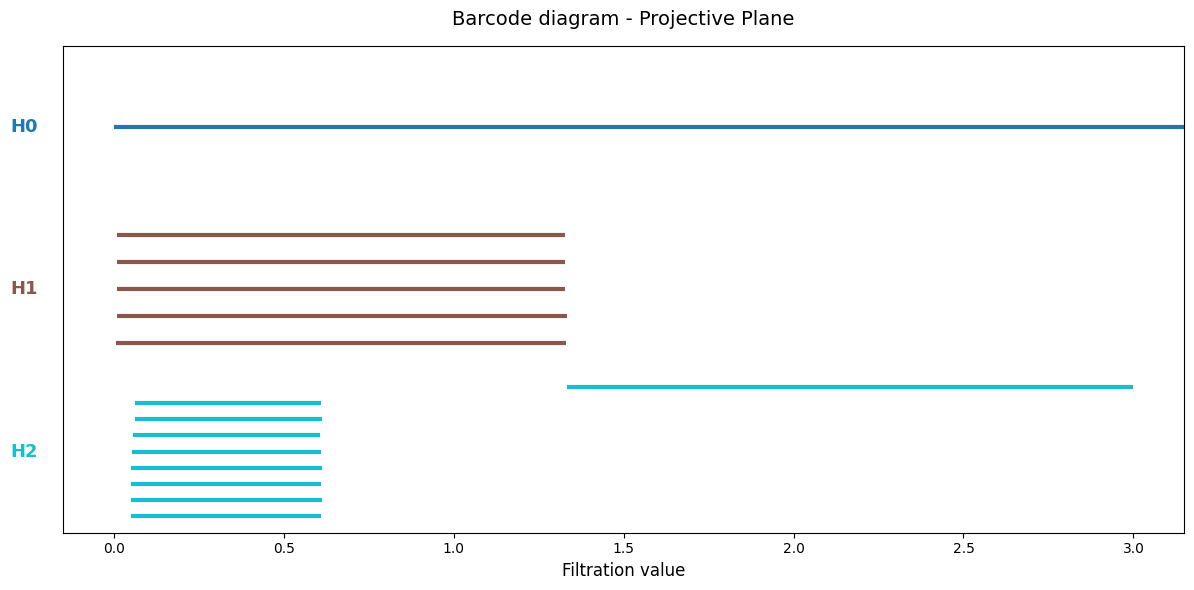

In [8]:
## Question 5 - Complexity analysis
filtration_a = read_filtration("filtrations/filtration_B.txt")
print("Filtration initialized.")
B = boundary_matrix(filtration_a)
print("Boundary matrix computed.")
barcodes = extract_barcodes(reduce_boundary_matrix(B), filtration_a)
print("Barcodes extracted.")
print_barcodes(barcodes)
plot_barcodes(barcodes, name="Projective Plane")

## TODO list


In [9]:
# TODO : report, answer questions, complexity analysis, plots, analysis of graphs, 2 3 pages. 
# >>> jupyter notebook
# + représentation graphique + tableau des temps

Filtration initialization


Computing boundary matrix: 100%|██████████| 55/55 [00:00<00:00, 217628.98it/s]


Boundary matrix computed.


Reducing boundary matrix: 100%|██████████| 55/55 [00:00<00:00, 358766.28it/s]


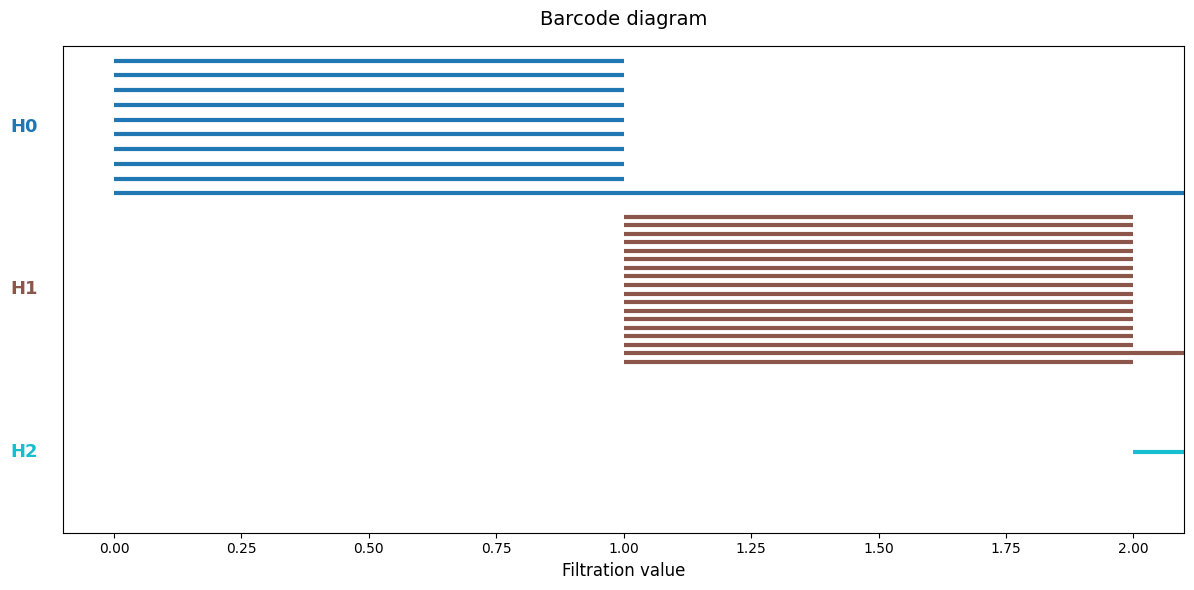

In [10]:
from itertools import combinations

def create_filtration(shape = "ball", dim = 10):
    # énumérer les parties d'une liste de points
    if shape == "ball":
        points = list(range(dim + 1))
    elif shape == "sphere":
        points = list(range(dim + 2))
    else:
        raise Exception("Shape should be \"ball\" or \"sphere\"")

    filtration = []
    for r in range(1, dim+1):
        for comb in combinations(points, r):
            filtration.append({"vert": set(comb), "dim": r - 1, "time": r})

    return filtration


filtration_a = read_filtration("filtrations/filtration_projective_plane.txt")
print("Filtration initialization")
B = boundary_matrix(filtration_a)
print("Boundary matrix computed.")
plot_barcodes(extract_barcodes(reduce_boundary_matrix(B), filtration_a))